# Hands-on Workshop - *Predicting product ratings from reviews*

This workshop is focused on the creation, deployment, monitoring and management of a machine learning model for predicting product ratings from reviews.

### Tom - this isn't completely relevant anymore, will change it before workshop to talk about pretrained model being used etc, so just ignore for now

In this notebook we will be exploring the data, and training the machine learning model itself; in the form of a Tensorflow Keras model. We will then deploy a second Tensorflow model with differing architecture as a Canary model to demonstrate the A/B testing functionality Seldon provides. Then we will begin to add the advanced monitoring and explainability that Seldon Alibi is famed for. 

-----------------------------------
Firstly, we will install and import the relevant packages which we will use throughout the exploration, training, and deployment process. 

In [ ]:
# Install those not pre-installed on Google colab

!pip install datasets
!pip install transformers

In [25]:
import pandas as pd
import numpy as np
import datasets

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from transformers import TFDistilBertForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification, create_optimizer
import tensorflow as tf
from tensorflow.data import Dataset

In [4]:
pd.set_option('mode.chained_assignment', None)

In [5]:
!gsutil cp gs://kelly-seldon/nlp-ratings/review_data.csv review_data.csv

Copying gs://kelly-seldon/nlp-ratings/review_data.csv...
\ [1 files][ 11.3 MiB/ 11.3 MiB]                                                
Operation completed over 1 objects/11.3 MiB.                                     


In [35]:
df = pd.read_csv("review_data.csv", delimiter=";")

df['review'] = df['review'].astype(str)
df['rating'] = df['rating'].astype(str)

rating_mapping = {
    '1.0': 0,
    '1.5': 1,
    '2.0': 2,
    '2.5': 3,
    '3.0': 4,
    '3.5': 5,
    '4.0': 6, 
    '4.5': 7,
    '5.0': 8
}

df['label'] = df['rating'].apply(lambda x: rating_mapping[x])
df.drop(columns=['product', 'user_id', 'date_created', 'rating'], axis=1, inplace=True)

df.head()

,review,label
0,"_product_ provided me with a pretty good, sec...",8
1,it protects our files and computer and very si...,6
2,"like most businesses, we are always looking fo...",8
3,we believed _product_ was a great solution for...,4
4,i formerly used _product_ and was relieved to ...,6


### Tom - I'm worried that the labels are so skewed the model won't be able to predict the lower ratings/.5 ratings well

In [36]:
df.label.value_counts()

8    31721
6    14017
4     2645
0      763
2      625
7      150
5       27
3       27
1       25
Name: label, dtype: int64

### Tom - did have validation split in here too, but don't think I need that if not fine-tuning the model.

In [7]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [8]:
train_ds = datasets.Dataset.from_pandas(train, preserve_index=False)
test_ds = datasets.Dataset.from_pandas(test, preserve_index=False)
comp_ds = datasets.DatasetDict({"train":train_ds,"test":test_ds})

### Tom - all of this is from following the article https://huggingface.co/docs/transformers/tasks/sequence_classification

In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Create a preprocessing function to tokenize text and truncate sequences to be no longer than DistilBERT’s maximum input length

In [10]:
def preprocess_function(examples):
    return tokenizer(examples['review'], truncation=True)

In [11]:
tokenized_revs = comp_ds.map(preprocess_function, batched=True)

  0%|          | 0/35 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [14]:
tf_train_set = tokenized_revs["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = tokenized_revs["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [15]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_revs['train']) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

### Tom - How does it know to map the labels to the correct labels in the reviews data? Without seeing the training data? There's surely a step missing here that needs adding in if not doing the fine tuning part? Does it need an argument for 

In [16]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=9)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

### Tom - Can ignore this - another example I found online of fine-tuning DistilBert

In [26]:
# model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=9)

# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
# model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_39', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [28]:
# model.fit(tf_train_set.shuffle(1000).batch(16), epochs=3, batch_size=16,
#           validation_data=tf_test_set.shuffle(1000).batch(16))

Epoch 1/3


TypeError: in user code:

    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/modeling_tf_utils.py", line 996, in train_step
        y_pred = self(x, training=True)
    File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "tf_distil_bert_for_sequence_classification_1" (type TFDistilBertForSequenceClassification).
    
    in user code:
    
        File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/modeling_tf_utils.py", line 730, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 742, in call  *
            distilbert_output = self.distilbert(
        File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "distilbert" (type TFDistilBertMainLayer).
        
        in user code:
        
            File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/modeling_tf_utils.py", line 730, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 400, in call  *
                embedding_output = self.embeddings(input_ids, inputs_embeds=inputs_embeds)  # (bs, seq_length, dim)
            File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
        
            TypeError: Exception encountered when calling layer "embeddings" (type TFEmbeddings).
            
            in user code:
            
                File "/home/seldon/anaconda3/lib/python3.7/site-packages/transformers/models/distilbert/modeling_tf_distilbert.py", line 122, in call  *
                    final_embeddings = self.LayerNorm(inputs=final_embeddings)
                File "/home/seldon/anaconda3/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
                    raise e.with_traceback(filtered_tb) from None
            
                TypeError: Exception encountered when calling layer "LayerNorm" (type LayerNormalization).
                
                Failed to convert elements of [1, 1, None, 1] to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
                
                Call arguments received:
                  • inputs=tf.Tensor(shape=(None, 16, None, 768), dtype=float32)
            
            
            Call arguments received:
              • input_ids=tf.Tensor(shape=(None, 16, None), dtype=int64)
              • position_ids=None
              • inputs_embeds=None
              • training=True
        
        
        Call arguments received:
          • self=tf.Tensor(shape=(None, 16, None), dtype=int64)
          • input_ids=None
          • attention_mask=tf.Tensor(shape=(None, 16, None), dtype=int64)
          • head_mask=None
          • inputs_embeds=None
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received:
      • self={'input_ids': 'tf.Tensor(shape=(None, 16, None), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(None, 16, None), dtype=int64)', 'labels': 'tf.Tensor(shape=(None, 16), dtype=int64)'}
      • input_ids=None
      • attention_mask=None
      • head_mask=None
      • inputs_embeds=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • labels=None
      • training=True


### Tom - Need to add accuracy metric in here too, but got error about using internal loss function meaning you can't specify additional metrics

In [17]:
model.compile(
    optimizer=optimizer
)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour, please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


### Tom - tf_test_set - the reviews has been tokenised. Does the tokeniser need embedding in the model? Otherwise a preprocesser will be needed in order to pass raw text to the model?

In [23]:
loss = model.evaluate(tf_test_set)

703/938 [=====================>........] - ETA: 4:02 - loss: 2.1695

KeyboardInterrupt: 

## Tom - from here down not used anymore - this was messing to build a custom model

In [445]:
weights

{0: 0.17513809638900274,
 1: 0.3963441218203293,
 2: 2.1003990758244067,
 3: 7.2811999417504,
 4: 8.88888888888889,
 5: 37.03703703703704,
 6: 205.76131687242798,
 7: 205.76131687242798,
 8: 222.22222222222223}

Convert dataset into tensorflow dataset.

In [446]:
ds_train = Dataset.from_tensor_slices((train['review'].values, train['rating'].values))
ds_test = Dataset.from_tensor_slices((test['review'].values, test['rating'].values))
ds_val = Dataset.from_tensor_slices((val['review'].values, val['rating'].values))

Covert categorical target variable to numeric variable.

In [253]:
ct0, ct1, ct2, ct3, ct4, ct5, ct6, ct7, ct8 = np.bincount(y_train)
total = len(df)

weight_for_0 = (1 / ct0) * (total / 9.0)
weight_for_1 = (1 / ct1) * (total / 9.0)
weight_for_2 = (1 / ct2) * (total / 9.0)
weight_for_3 = (1 / ct3) * (total / 9.0)
weight_for_4 = (1 / ct4) * (total / 9.0)
weight_for_5 = (1 / ct5) * (total / 9.0)
weight_for_6 = (1 / ct6) * (total / 9.0)
weight_for_7 = (1 / ct7) * (total / 9.0)
weight_for_8 = (1 / ct8) * (total / 9.0)

class_weights = {
    0: weight_for_0, 
    1: weight_for_1, 
    2: weight_for_2, 
    3: weight_for_3,
    4: weight_for_4,
    5: weight_for_5,
    6: weight_for_6,
    7: weight_for_7,
    8: weight_for_8
}

In [302]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 150

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

In [303]:
int_vectorize_layer.adapt(X_train)

In [304]:
def int_vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return int_vectorize_layer(text), label

In [311]:
y_train = to_categorical(y_train)

In [312]:
int_train_ds = int_vectorize_text(X_train, y_train)
int_val_ds = int_vectorize_text(X_val, y_val)
int_test_ds = int_vectorize_text(X_test, y_test)

In [313]:
int_train_ds

(<tf.Tensor: shape=(33750, 150), dtype=int64, numpy=
 array([[  6,  83,  35, ...,   0,   0,   0],
        [733,   3,  31, ...,   0,   0,   0],
        [ 40,   4,  45, ...,   0,   0,   0],
        ...,
        [  6,  18,  19, ...,   0,   0,   0],
        [ 40,  57,  11, ...,   0,   0,   0],
        [  6, 183,   5, ...,   0,   0,   0]])>,
 array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32))

**Embedding layer**

Input shape:
2D tensor with shape: (batch_size, input_length).

Output shape:
3D tensor with shape: (batch_size, input_length, output_dim).

*Do I have this right at the moment? I have input length as the vocab size... should output_dim be 9? What should it be?*

input_length = Integer. Size of the vocabulary, i.e. maximum integer index + 1.

output_dim = Integer. Dimension of the dense embedding.


**Conv1D layer**

Should it not be 16 here?... filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

Should it not be 5 here?... kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.

Do I need an input_shape argument? I don't know if I do as it's not the first layer? Embedding is the first layer?


In [327]:
test_shape = int_train_ds[0].reshape(len(int_train_ds[0]), int_train_ds[0].shape[1],1)

In [326]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [336]:
# Input
from tensorflow.keras.layers import Input

in_shape = (test_shape.shape[1],1)
inputs = Input(shape=(in_shape), name='inputs_cnn')

In [337]:
inputs

<KerasTensor: shape=(None, 150, 1) dtype=float32 (created by layer 'inputs_cnn')>

In [323]:
int_train_ds[0]

<tf.Tensor: shape=(33750, 150), dtype=int64, numpy=
array([[  6,  83,  35, ...,   0,   0,   0],
       [733,   3,  31, ...,   0,   0,   0],
       [ 40,   4,  45, ...,   0,   0,   0],
       ...,
       [  6,  18,  19, ...,   0,   0,   0],
       [ 40,  57,  11, ...,   0,   0,   0],
       [  6, 183,   5, ...,   0,   0,   0]])>

In [355]:
def create_model(vocab_size, num_labels, input_shape):
    model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 1024, mask_zero=True, input_shape=input_shape),
      layers.Conv1D(1024, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
    ])
    return model

In [356]:
# `vocab_size` is `VOCAB_SIZE + 1` since `0` is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=9, input_shape=in_shape)
int_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(
    inputs, 
    int_train_ds[1], 
#     validation_data=(int_val_ds[0], int_val_ds[1]), 
    epochs=15,
    class_weight=class_weights
)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d_34. Consider increasing the input size. Received input shape [None, 150, 1, 1024] which would produce output shape with a zero or negative value in a dimension.

In [274]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [275]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (12, 10)

In [276]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend();

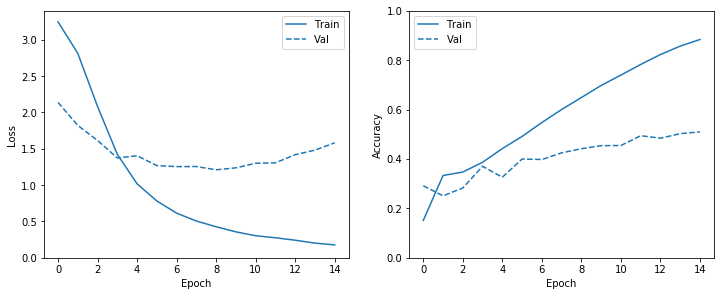

In [286]:
plot_metrics(history)

In [287]:
int_loss, int_accuracy = int_model.evaluate(int_test_ds[0], int_test_ds[1])

print("Int model accuracy: {:2.2%}".format(int_accuracy))

157/157 [==============================] - 0s 1ms/step - loss: 1.5388 - accuracy: 0.5240
Int model accuracy: 52.40%


In [288]:
predictions = int_model.predict(int_test_ds[0])
print(predictions[:1])

[[-12.551326   -14.205595   -10.307593    -6.996902    -6.236613
  -11.317929    14.247541     0.38065982  15.718541  ]]


In [289]:
print(predictions)

[[-12.551326   -14.205595   -10.307593   ...  14.247541     0.38065982
   15.718541  ]
 [ -2.5539522  -11.087661     2.168796   ...   0.59642243  -8.97046
    5.491527  ]
 [-14.290668   -13.789915    -4.7460256  ...  11.998764     1.4773175
   13.5251255 ]
 ...
 [-16.912428   -18.866726   -10.535642   ...   7.2865367   -3.2117934
   10.618746  ]
 [ -7.1668673  -10.601623    -6.650805   ...  -4.0072656   -5.804961
   -0.5142288 ]
 [ -3.5702062   -6.9096284   -2.2240076  ...  -1.6571041   -4.138695
    0.28596228]]


In [290]:
test_re = int_test_ds[1].reset_index(drop=True)

In [291]:
test_val_list = []
pred_val_list = []

for i in range(0,len(test_re)):
    test_val = test_re[i]
    test_val_list.append(test_val)
    pred_val = list(predictions[i]).index(predictions[i].max())
    pred_val_list.append(pred_val)

In [292]:
df_results = pd.DataFrame(
        {'Test_val':test_val_list,
            'Pred_val':pred_val_list}

)

In [293]:
df_results

,Test_val,Pred_val
0,2,8
1,6,8
2,8,8
3,8,8
4,8,6
...,...,...
4995,8,8
4996,8,6
4997,8,8
4998,6,8


In [294]:
df_results['match']='False'
df_results.loc[df_results['Test_val']==df_results['Pred_val'],'match'] = 'True'

In [295]:
df_group = df_results.groupby(['Test_val','match']).count()

In [296]:
df_results['Pred_val'].value_counts(normalize=True)

8    0.6066
6    0.3024
4    0.0510
0    0.0196
2    0.0166
7    0.0024
3    0.0008
5    0.0004
1    0.0002
Name: Pred_val, dtype: float64

In [298]:
df_group

Pred_val
Test_val match          
0        False        55
         True         26
1        False         1
2        False        46
         True          5
4        False       246
         True         37
5        False         1
         True          1
6        False       901
         True        472
7        False        14
         True          1
8        False      1116
         True       2078